# 1. Setup and Load Data

## 1.1 Import Dependencies and Setup

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

In [3]:
DATASET_PATH = "C:/Users/bluew/Downloads/dataset"
species = os.listdir(DATASET_PATH)
len(species)

100

# 2. Preprocess Images

## 2.1 Set Parameters

In [4]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

## 2.2 Load Dataset and split into training & validation sets

In [5]:
# Training dataset
train_dataset = tf.keras.utils.image_dataset_from_directory(
    DATASET_PATH,
    validation_split=0.3,
    subset="training",
    seed=123,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

# Validation+Test dataset
val_test_dataset = tf.keras.utils.image_dataset_from_directory(
    DATASET_PATH,
    validation_split=0.3,
    subset="validation",
    seed=123,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

val_size = int(tf.data.experimental.cardinality(val_test_dataset).numpy() * 0.5)

# Split val_test_dataset into validation and test datasets
val_dataset = val_test_dataset.take(val_size)
test_dataset = val_test_dataset.skip(val_size)

# Class names
dataset_categories = train_dataset.class_names

Found 77382 files belonging to 100 classes.
Using 54168 files for training.
Found 77382 files belonging to 100 classes.
Using 23214 files for validation.


## 2.3 Normalize the images

In [6]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
val_dataset = val_dataset.map(lambda x, y: (normalization_layer(x), y))
test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y))

## 2.4 Prefetch Images to Improve Performance

In [7]:
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

## 2.5 Plot some images

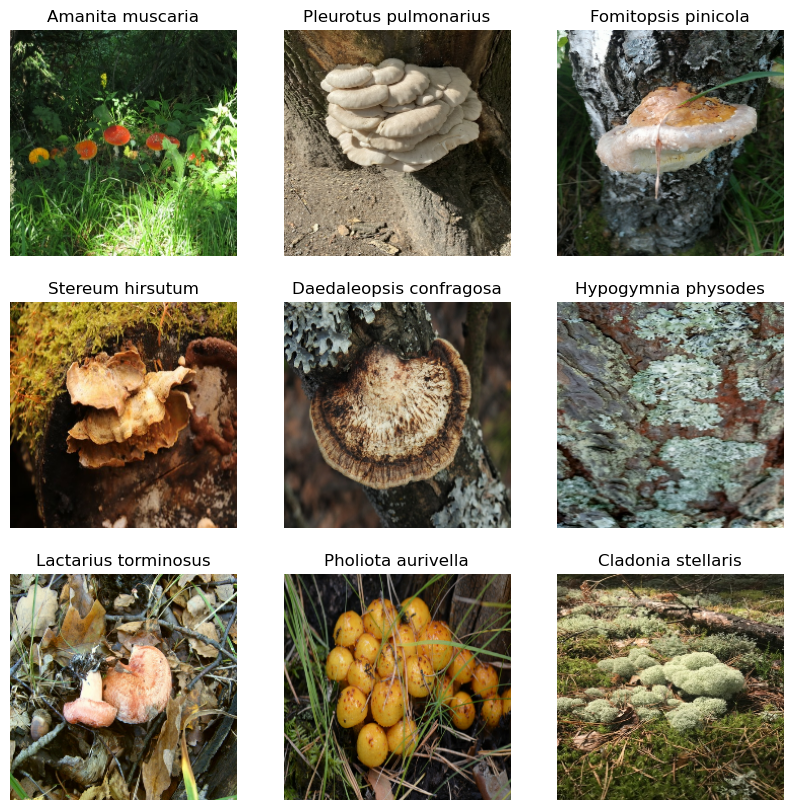

In [8]:
plt.figure(figsize=(10, 10))
for image, labels in train_dataset.take(1):
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        # Convert image[i] from float32 to uint8 (0-255 range)
        img = image[i].numpy() * 255.0  # scale back to 0-255
        img = img.astype(np.uint8)      # convert to uint8
        plt.imshow(img)
        plt.title(dataset_categories[labels[i]])
        plt.axis('off')

plt.show()

# 3. Building the Model

In [9]:
from tensorflow.keras.models import Sequential

# Load MobileNetV2 without the top layer to use as the base model
base_model = keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

# Freeze pre-trained layers
base_model.trainable = False

model = Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1024, activation='relu'),
    layers.Dense(len(dataset_categories), activation='softmax') 
])

# Compile
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)              1311744   
                                                                 
 dense_1 (Dense)             (None, 100)               102500    
                                                                 
Total params: 3,672,228
Trainable params: 1,414,244
Non-trainable params: 2,257,984
_________________________________________________________________


# 4. Training the Model

## 4.1 Training

In [10]:
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset
)

Epoch 1/10
1693/1693 [==============================] - 866s 376ms/step - loss: 1.6439 - accuracy: 0.5842 - val_loss: 1.1844 - val_accuracy: 0.6748
Epoch 2/10
1693/1693 [==============================] - 450s 266ms/step - loss: 1.0087 - accuracy: 0.7118 - val_loss: 1.0759 - val_accuracy: 0.6939
Epoch 3/10
1693/1693 [==============================] - 387s 228ms/step - loss: 0.8558 - accuracy: 0.7524 - val_loss: 1.0015 - val_accuracy: 0.7146
Epoch 4/10
1693/1693 [==============================] - 373s 220ms/step - loss: 0.7531 - accuracy: 0.7784 - val_loss: 0.9857 - val_accuracy: 0.7155
Epoch 5/10
1693/1693 [==============================] - 391s 231ms/step - loss: 0.6694 - accuracy: 0.8033 - val_loss: 0.9714 - val_accuracy: 0.7197
Epoch 6/10
1693/1693 [==============================] - 385s 228ms/step - loss: 0.6000 - accuracy: 0.8243 - val_loss: 0.9518 - val_accuracy: 0.7295
Epoch 7/10
1693/1693 [==============================] - 375s 222ms/step - loss: 0.5392 - accuracy: 0.8431 - val_

In [11]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("GPUs available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.10.0
GPUs available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## 4.2 Plotting training history

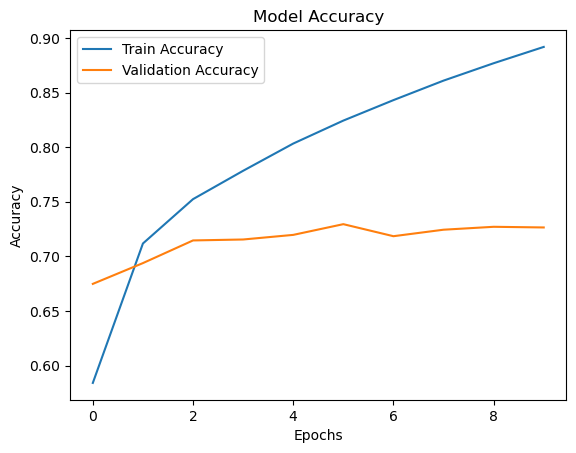

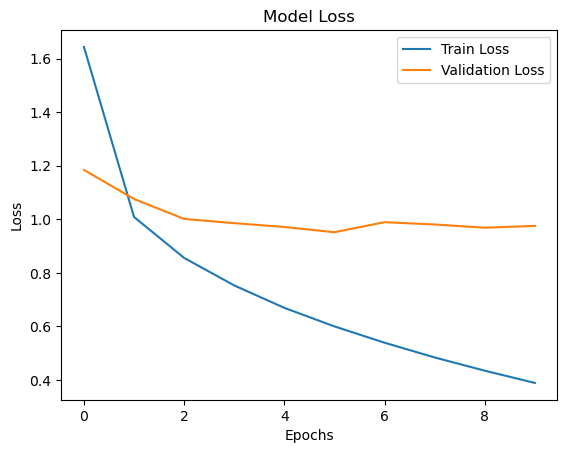

In [12]:
import matplotlib.pyplot as plt

# Plot the training and validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot the training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 5. Evaluating the model

In [13]:
model.save("mushroom_classifier.h5")

In [1]:
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

NameError: name 'model' is not defined